In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import joblib
import os

In [38]:
#  save models
os.makedirs("../models", exist_ok=True)

In [39]:
# Load Data
data = yf.download('TSLA', start='2015-01-01', end='2024-10-31')
data = data['Close']  
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [40]:
# Split Data into Training and Testing Sets (80-20 split)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [41]:
# Function to Calculate Evaluation Metrics
def evaluate_forecast(test, predictions):
    mae = mean_absolute_error(test, predictions)
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')
    return mae, rmse, mape

In [42]:
# Manually define the ARIMA order (p, d, q) parameters
arima_order = (5, 1, 0) 

# Train ARIMA Model
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()

/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [43]:
# Save ARIMA model
joblib.dump(arima_fit, "../models/arima_model.pkl")

['../models/arima_model.pkl']

In [44]:
# Make Predictions
arima_predictions = arima_fit.forecast(steps=len(test))
evaluate_forecast(test, arima_predictions)

MAE: 39.313251901468895, RMSE: 49.56620021820765, MAPE: nan


/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(np.float64(39.313251901468895), 49.56620021820765, nan)

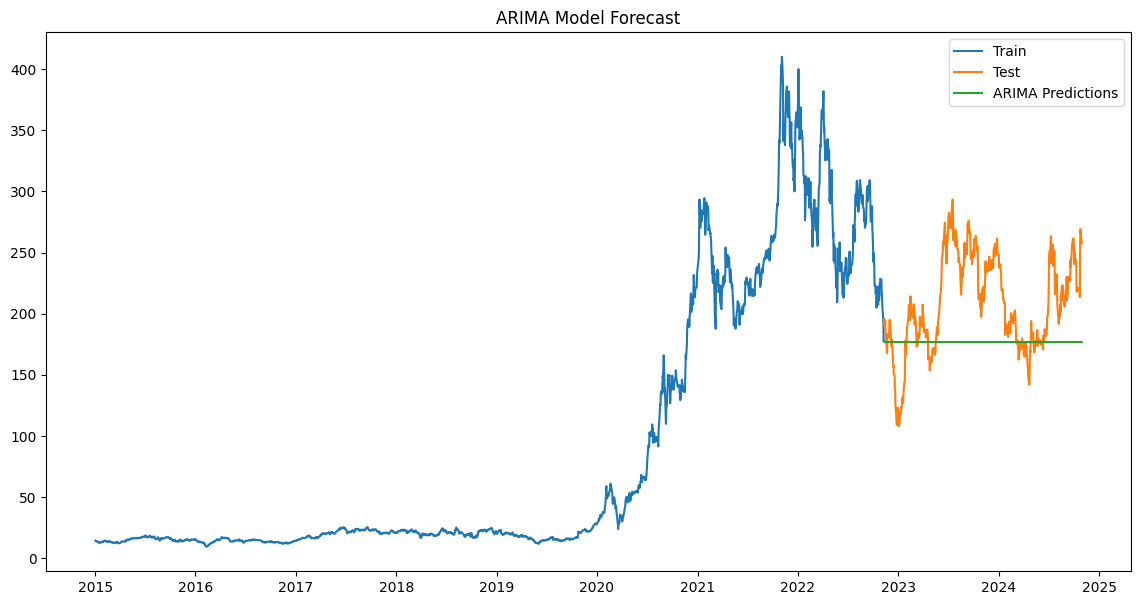

In [45]:
# Plot Predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_predictions, label='ARIMA Predictions')
plt.title("ARIMA Model Forecast")
plt.legend()
plt.show()

In [46]:

sarima_order = (1, 1, 1)  
sarima_seasonal_order = (1, 1, 1, 12)  

# Train SARIMA Model
sarima = SARIMAX(train, order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_fit = sarima.fit(disp=False)  

# Save SARIMA model
joblib.dump(sarima_fit, "../models/sarima_model.pkl")


/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


['../models/sarima_model.pkl']

In [47]:
# Make Predictions
sarima_predictions = sarima_fit.forecast(steps=len(test))
evaluate_forecast(test, sarima_predictions)

MAE: 31.905939552762536, RMSE: 39.560906593967296, MAPE: nan


/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(np.float64(31.905939552762536), 39.560906593967296, nan)

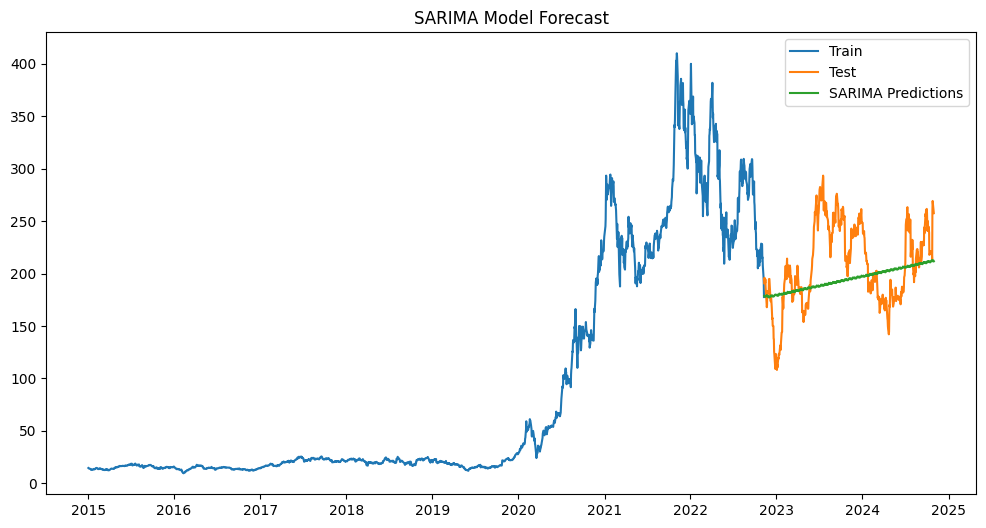

In [48]:
# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions')
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

In [49]:
# 3. LSTM Model
# Prepare data for LSTM (reshape into 3D array)
train_data_gen = TimeseriesGenerator(train.values, train.values, length=60, batch_size=32)
test_data_gen = TimeseriesGenerator(test.values, test.values, length=60, batch_size=32)

In [50]:
# Define LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
# Compile and Train LSTM Model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_data_gen, epochs=20, validation_data=test_data_gen, verbose=1)

Epoch 1/20


/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 28896.7383 - val_loss: 44397.1523
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 10887.6826 - val_loss: 42742.4727
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 15773.4502 - val_loss: 41713.1367
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 22665.0176 - val_loss: 40911.6602
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 18396.1016 - val_loss: 40170.9414
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 22411.0059 - val_loss: 39513.9180
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 13551.9756 - val_loss: 38911.2383
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 22984.8223 - val_loss: 38201.4453
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 18368.2715 - val_loss: 37577.6523
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17085.2266 - val_loss: 36979.3438
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 20113.6016 - val_los

In [52]:
# Save LSTM model
lstm_model.save("../models/lstm_model.h5")

In [53]:
# Make Predictions
lstm_predictions = lstm_model.predict(test_data_gen)
evaluate_forecast(test[60:], lstm_predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 174.52669513746238, RMSE: 177.86142422135322, MAPE: 80.70365917339898


(np.float64(174.52669513746238),
 177.86142422135322,
 np.float64(80.70365917339898))

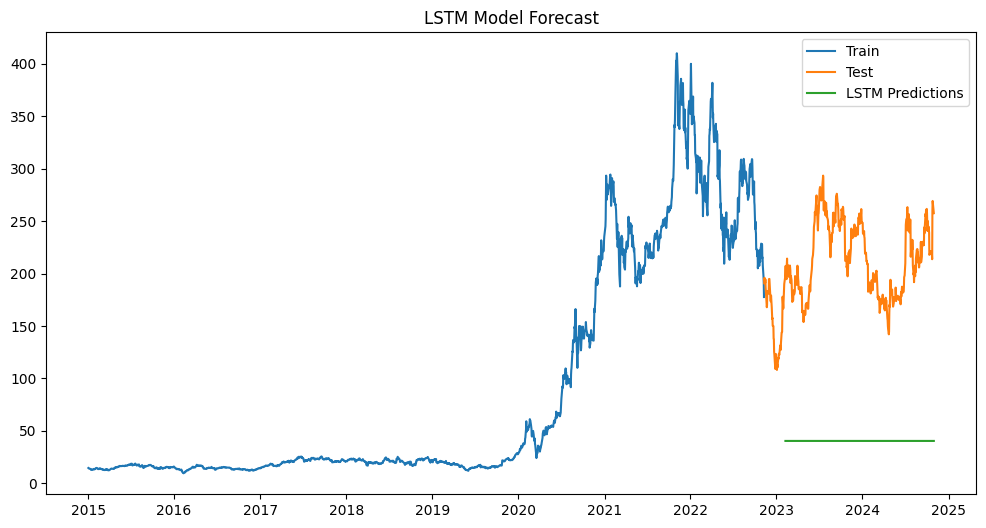

In [54]:
# Plot LSTM Predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index[60:], lstm_predictions, label='LSTM Predictions')
plt.title("LSTM Model Forecast")
plt.legend()
plt.show()